---
title: "Dataset Split & Exploration"
author: "Guntas Singh Saran"
date: "2025-02-13"
image: "output.png"
format:
    html:
        code-fold: false
        code-tools: true
jupyter: python3
---

In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import random
import pandas as pd
from collections import Counter
import cv2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
images_dir = "./data/images"
labels_dir = "./data/labels"

In [45]:
images_base = set([f.split('.')[0] for f in os.listdir(images_dir)])
labels_base = set([f.split('.')[0] for f in os.listdir(labels_dir)])

intersection = images_base.intersection(labels_base)
uncommon_files = images_base.symmetric_difference(labels_base)

images = [f for f in os.listdir(images_dir) if f.split('.')[0] in intersection]
labels = [f for f in os.listdir(labels_dir) if f.split('.')[0] in intersection]

images_ = [f.split('.')[0] for f in sorted(images)]
labels_ = [f.split('.')[0] for f in sorted(labels)]

In [48]:
data = []
for img, lbl in zip(images_, labels_):
    with open(os.path.join(labels_dir, lbl + ".txt"), 'r') as f:
        class_ids = [line.split()[0] for line in f]
    with open(os.path.join(labels_dir, lbl + ".txt"), 'r') as f:
        str = f.read()
        
    if class_ids:
        class_ids = Counter(class_ids)
        data.append((img, str, class_ids['0'], class_ids['1'], class_ids['2']))

df = pd.DataFrame(data, columns=['image', 'label', 'Tile0', 'Tile1', 'Tile2'])

In [49]:
df

,image,label,Tile0,Tile1,Tile2
0,solarpanels_native_1__x0_0_y0_6845_dxdy_416,0 0.8725961538461539 0.7007211538461539 0.0576...,8,0,0
1,solarpanels_native_1__x0_0_y0_6963_dxdy_416,0 0.8725961538461539 0.4170673076923077 0.0576...,12,0,1
2,solarpanels_native_1__x0_0_y0_7119_dxdy_416,0 0.8725961538461539 0.042067307692307696 0.05...,17,0,1
3,solarpanels_native_1__x0_0_y0_7229_dxdy_416,0 0.875 0.013221153846153848 0.028846153846153...,14,0,1
4,solarpanels_native_1__x0_0_y0_7230_dxdy_416,0 0.875 0.01201923076923077 0.0288461538461538...,14,0,1
...,...,...,...,...,...
2537,solarpanels_native_3__x0_9952_y0_11824_dxdy_416,0 0.7524038461538461 0.34615384615384615 0.048...,5,0,0
2538,solarpanels_native_3__x0_9965_y0_11241_dxdy_416,0 0.9771634615384616 0.2403846153846154 0.0360...,3,0,0
2539,solarpanels_native_3__x0_9972_y0_12567_dxdy_416,0 0.4074519230769231 0.6490384615384616 0.1658...,2,0,0
2540,solarpanels_native_3__x0_9979_y0_10637_dxdy_416,0 0.30649038461538464 0.6598557692307693 0.074...,5,0,0


In [50]:
print("Original Dataset:\n", df['Tile0'].sum(), df['Tile1'].sum(), df['Tile2'].sum())

Original Dataset:
 29267 130 228


#### `MultilabelStratifiedKFold` ensure that each fold in a k-fold cross-validation retains the distribution of labels present in the original dataset. This is particularly useful when the dataset is imbalanced.

In [51]:
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [73]:
# 80-20 split of train-test
mskf = MultilabelStratifiedKFold(n_splits=5, shuffle=True)
X = df['image'].values
y = df[['Tile0', 'Tile1', 'Tile2']].values

for train_index, test_index in mskf.split(X, y):
    train = df.loc[train_index]
    test = df.loc[test_index]
    print(train['Tile0'].sum(), train['Tile1'].sum(), train['Tile2'].sum(), "\n", test['Tile0'].sum(), test['Tile1'].sum(), test['Tile2'].sum())
    break

print()

# 10% of train set for validation
mskf = MultilabelStratifiedKFold(n_splits=10, shuffle=True)
X_train = train['image'].values
y_train = train[['Tile0', 'Tile1', 'Tile2']].values

for train_index, val_index in mskf.split(X_train, y_train):
    train = df.loc[train_index]
    val = df.loc[val_index]
    print(train['Tile0'].sum(), train['Tile1'].sum(), train['Tile2'].sum(), "\n", val['Tile0'].sum(), val['Tile1'].sum(), val['Tile2'].sum())
    break
print()
# should be 72%, 20%, 8%
print(len(train)/len(df) * 100, len(test)/len(df) * 100, len(val)/len(df) * 100)

23424 102 181 
 5843 28 47

23765 114 171 
 2194 7 31

72.02989771833202 19.98426435877262 7.985837922895358


In [74]:
train_image_dir = "./data/train/images"
train_label_dir = "./data/train/labels"
test_image_dir = "./data/test/images"
test_label_dir = "./data/test/labels"
val_image_dir = "./data/val/images"
val_label_dir = "./data/val/labels"

os.makedirs(train_image_dir, exist_ok=True)
os.makedirs(train_label_dir, exist_ok=True)
os.makedirs(test_image_dir, exist_ok=True)
os.makedirs(test_label_dir, exist_ok=True)
os.makedirs(val_image_dir, exist_ok=True)
os.makedirs(val_label_dir, exist_ok=True)

In [75]:
for i, row in train.iterrows():
    shutil.copy(os.path.join(images_dir, row['image'] + ".tif"), train_image_dir)
    shutil.copy(os.path.join(labels_dir, row['image'] + ".txt"), train_label_dir)

for i, row in test.iterrows():
    shutil.copy(os.path.join(images_dir, row['image'] + ".tif"), test_image_dir)
    shutil.copy(os.path.join(labels_dir, row['image'] + ".txt"), test_label_dir)

for i, row in val.iterrows():
    shutil.copy(os.path.join(images_dir, row['image'] + ".tif"), val_image_dir)
    shutil.copy(os.path.join(labels_dir, row['image'] + ".txt"), val_label_dir)

In [76]:
len(os.listdir(train_image_dir)), len(os.listdir(train_label_dir)), len(os.listdir(test_image_dir)), len(os.listdir(test_label_dir)), len(os.listdir(val_image_dir)), len(os.listdir(val_label_dir)), len(images), len(labels)

(1831, 1831, 508, 508, 203, 203, 2542, 2542)

## Some play with the data

In [ ]:
df[df['Tile2'] == df['Tile2'].max()]

,image,label,Tile0,Tile1,Tile2
857,solarpanels_native_1__x0_8565_y0_11093_dxdy_416,2 0.671875 0.3137019230769231 0.08894230769230...,0,0,9
860,solarpanels_native_1__x0_8573_y0_11090_dxdy_416,2 0.6526442307692308 0.32091346153846156 0.088...,0,0,9
862,solarpanels_native_1__x0_8582_y0_11150_dxdy_416,2 0.6310096153846154 0.17668269230769232 0.088...,0,0,9
865,solarpanels_native_1__x0_8596_y0_11097_dxdy_416,2 0.5973557692307693 0.3040865384615385 0.0889...,0,0,9
871,solarpanels_native_1__x0_8623_y0_10945_dxdy_416,2 0.5324519230769231 0.6694711538461539 0.0889...,0,0,9
872,solarpanels_native_1__x0_8628_y0_10957_dxdy_416,2 0.5204326923076923 0.640625 0.08894230769230...,0,0,9
874,solarpanels_native_1__x0_8635_y0_10963_dxdy_416,2 0.5036057692307693 0.6262019230769231 0.0889...,0,0,9
877,solarpanels_native_1__x0_8664_y0_11014_dxdy_416,2 0.4338942307692308 0.5036057692307693 0.0889...,0,0,9
878,solarpanels_native_1__x0_8670_y0_11147_dxdy_416,2 0.41947115384615385 0.18389423076923078 0.08...,0,0,9


In [62]:
df[df['Tile1'] == df['Tile1'].max()]

,image,label,Tile0,Tile1,Tile2
1118,solarpanels_native_2__x0_14692_y0_14213_dxdy_416,1 0.670673076923077 0.4278846153846154 0.10096...,0,2,0
1119,solarpanels_native_2__x0_14813_y0_14131_dxdy_416,1 0.37980769230769235 0.625 0.1009615384615384...,0,2,0
1334,solarpanels_native_2__x0_5176_y0_6131_dxdy_416,1 0.9903846153846154 0.43028846153846156 0.019...,4,2,0
1335,solarpanels_native_2__x0_5184_y0_6305_dxdy_416,1 0.9807692307692308 0.05528846153846154 0.038...,5,2,0
1336,solarpanels_native_2__x0_5187_y0_6039_dxdy_416,1 0.9771634615384616 0.6514423076923077 0.0456...,9,2,0
1347,solarpanels_native_2__x0_5369_y0_6108_dxdy_416,0 0.8653846153846154 0.18629807692307693 0.038...,2,2,0
1353,solarpanels_native_2__x0_5426_y0_6012_dxdy_416,0 0.7283653846153847 0.4170673076923077 0.0384...,1,2,0
1361,solarpanels_native_2__x0_5549_y0_6002_dxdy_416,0 0.9375 0.7560096153846154 0.0336538461538461...,2,2,0
1363,solarpanels_native_2__x0_5588_y0_6163_dxdy_416,0 0.84375 0.36899038461538464 0.03365384615384...,4,2,0
1368,solarpanels_native_2__x0_5619_y0_5655_dxdy_416,0 0.24639423076923078 0.41466346153846156 0.10...,13,2,0


In [65]:
df[(df['Tile0'] > 0) & (df['Tile1'] > 0) & (df['Tile2'] > 0)]

,image,label,Tile0,Tile1,Tile2
778,solarpanels_native_1__x0_8158_y0_9952_dxdy_416,0 0.020432692307692308 0.8317307692307693 0.04...,4,1,1
796,solarpanels_native_1__x0_8233_y0_9890_dxdy_416,2 0.375 0.6117788461538461 0.10096153846153846...,4,1,1
819,solarpanels_native_1__x0_8356_y0_9984_dxdy_416,2 0.07932692307692309 0.3858173076923077 0.100...,4,1,1
821,solarpanels_native_1__x0_8366_y0_9849_dxdy_416,2 0.05528846153846154 0.7103365384615385 0.100...,6,1,1
822,solarpanels_native_1__x0_8385_y0_9752_dxdy_416,2 0.030048076923076924 0.9435096153846154 0.06...,4,1,1
825,solarpanels_native_1__x0_8393_y0_10108_dxdy_416,2 0.020432692307692308 0.08774038461538462 0.0...,6,1,1
2208,solarpanels_native_3__x0_6464_y0_13626_dxdy_416,0 0.9639423076923077 0.11538461538461539 0.038...,2,1,1


In [69]:
df[df["Tile0"] == df["Tile0"].max()]

,image,label,Tile0,Tile1,Tile2
1450,solarpanels_native_2__x0_714_y0_10614_dxdy_416,0 0.7379807692307693 0.007211538461538462 0.26...,78,0,0


## Annotations from the dataset

In [58]:
def give_image(filename):
    fileIm = f"./data/images/{filename}.tif"
    fileLb = f"./data/labels/{filename}.txt"
    
    im = cv2.imread(fileIm)
    
    with open(fileLb, 'r') as f:
        lines = f.readlines()
        
    for line in lines:
        line = line.strip().split()
        class_id, x_center, y_center, width, height = map(float, line)
        x_center, y_center = int(x_center * im.shape[1]), int(y_center * im.shape[0])
        width, height = int(width * im.shape[1]), int(height * im.shape[0])
        
        x1, y1 = x_center - width // 2, y_center - height // 2
        x2, y2 = x_center + width // 2, y_center + height // 2

        if class_id == 0:
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 255, 0), 2)
        elif class_id == 1:
            cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)
        elif class_id == 2:
            cv2.rectangle(im, (x1, y1), (x2, y2), (0, 0, 255), 2)
        
    plt.figure(figsize=(6, 6))
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

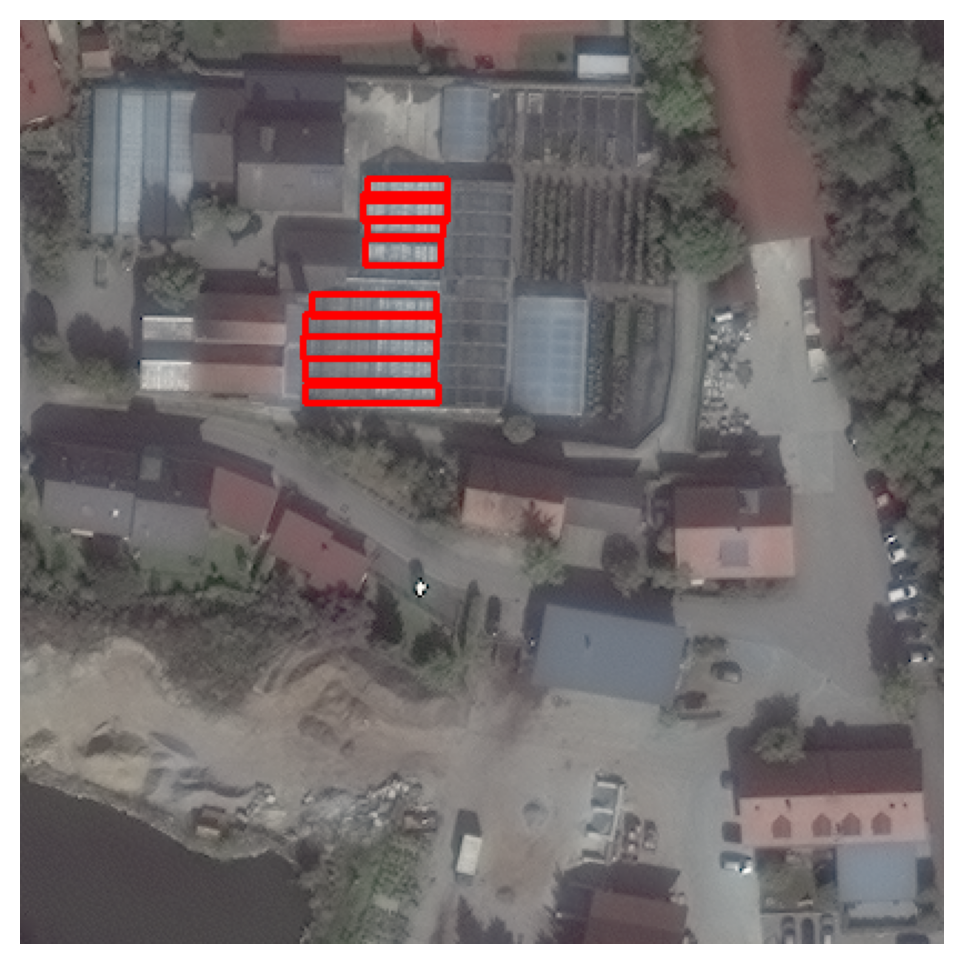

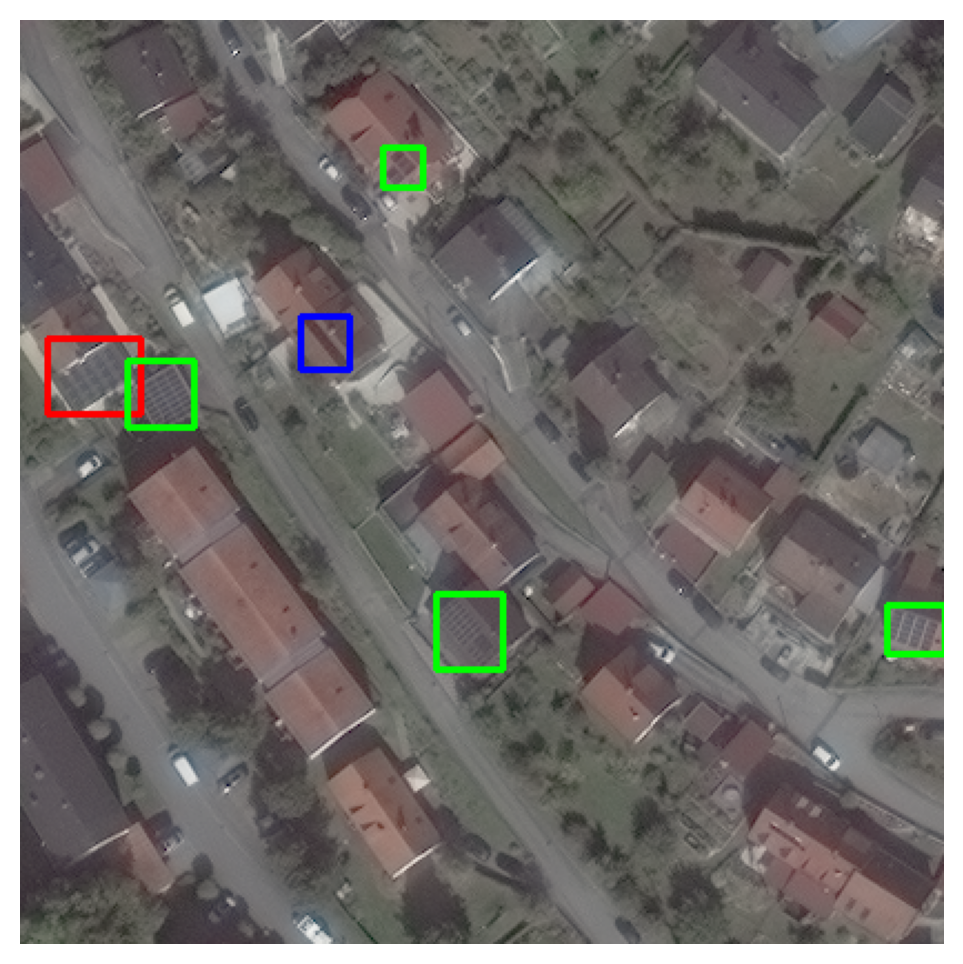

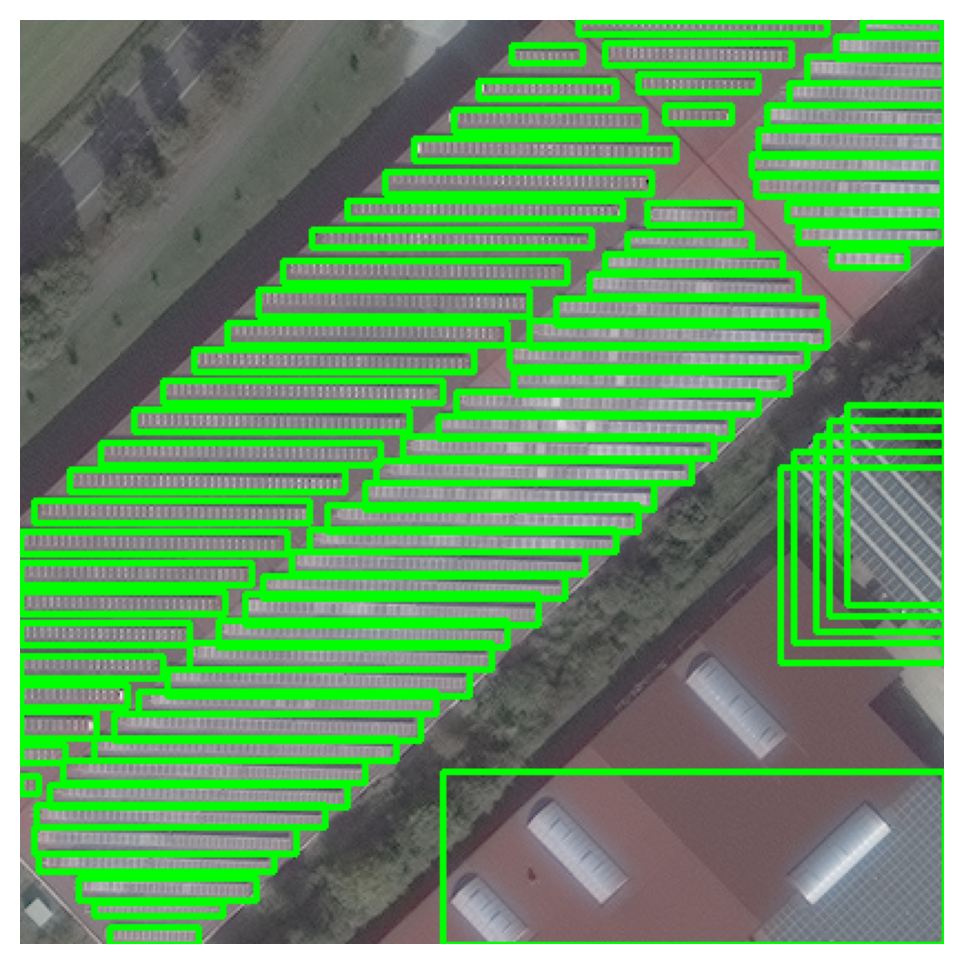

In [71]:
give_image(images_[878])
give_image(images_[819])
give_image(images_[1450])